# Reproducing Marrel et al. (2010) spatial Sobol' maps on Campbell2D

This notebook reproduces the pipeline in:

Marrel, A., Iooss, B., Laurent, B., & Roustant, O. (2010). *Global sensitivity analysis for models with spatially dependent outputs*.  
Preprint: https://arxiv.org/pdf/0911.1189

We follow the Campbell2D study choices reported in the paper:

- Spatial grid: 64×64 (nz = 4096)
- Input dimension: d=8, Xi ~ Unif[-1,5]
- Learning sample: n=200 maximin LHS
- Wavelet: Daubechies (implemented here as `db4`)
- Method 3 for coefficient surrogates:
  - GP on k* = 30 most variable wavelet coefficients
  - Linear regression on k′ = 500 following coefficients
  - Empirical mean for remaining coefficients
- Reference “exact” Sobol maps:
  - Paper: analytic first-order + Saltelli MC total-effect with N=1e5  
  - Here: Saltelli MC for both first-order and total maps (streamed) with N=1e5 by default

**Runtime notes**: the default settings can be heavy (exact Saltelli N=1e5 and nested MC for Sobol on metamodel).  
For quick iteration, reduce `cfg.saltelli_N_exact` and nested-MC counts in the “Parameters” cell.


In [1]:
# Notebook path/bootstrap so `marrel_pipeline` can be imported without relative imports.
import sys
from pathlib import Path

# If launched from project root, cwd contains `marrel_pipeline/`.
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "marrel_pipeline").exists():
    # If launched from notebooks/, go up one.
    PROJECT_ROOT = PROJECT_ROOT.parents[0]
    if not (PROJECT_ROOT / "marrel_pipeline").exists():
        # Fallback: go up two.
        PROJECT_ROOT = Path.cwd().resolve().parents[1]

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import matplotlib.pyplot as plt

from marrel_pipeline.config import DEFAULTS
from marrel_pipeline.campbell2d import make_spatial_grid, campbell2d_map
from marrel_pipeline.pipeline import (
    build_training_data,
    wavelet_decompose_training,
    order_coefficients_by_variance,
    fit_functional_metamodel,
)
from marrel_pipeline.functional_metamodel import predict_map_from_models
from marrel_pipeline.diagnostics import mse_q2, rmae
from marrel_pipeline.sobol_exact import saltelli_exact_sobol_maps
from marrel_pipeline.sobol_metamodel import nested_mc_sobol_maps
from marrel_pipeline.plotting import plot_map, plot_index_grid


## Parameters (paper defaults + optional fast mode)

In [2]:
cfg = DEFAULTS

# ---- Optional: set FAST=True for a shorter run ----
FAST = True
if FAST:
    cfg = type(cfg)(**{**cfg.__dict__,
        "saltelli_N_exact": 20_000,
        "mc_outer_first": 80,
        "mc_inner_first": 200,
        "mc_outer_total": 80,
        "mc_inner_total": 200,
        "mc_varY": 4000
    })

print(cfg)


MarrelConfig(d=8, x_low=-1.0, x_high=5.0, grid_n1=64, grid_n2=64, z_low=-90.0, z_high=90.0, n_train=200, K=4096, k_gp=30, k_lin=500, saltelli_N_exact=20000, mc_outer_first=80, mc_inner_first=200, mc_outer_total=80, mc_inner_total=200, mc_varY=4000, wavelet='db4', wavelet_level=6, frk_levels=3, frk_knots_per_level=(10, 15, 20), frk_radius_factor=2.5, frk_lambda_pen=0.01, frk_add_intercept=False)


## Step A: Build spatial grid and visualize Campbell2D example maps (Fig. 1 style)

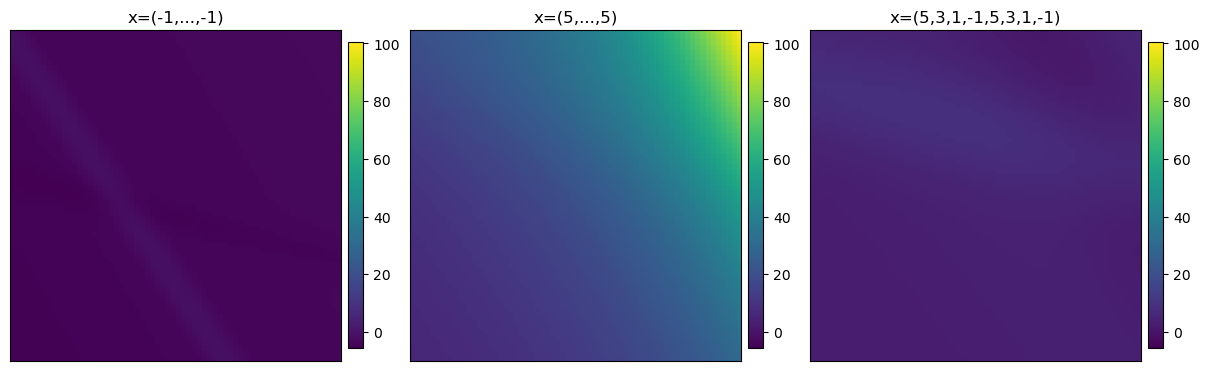

In [3]:
Z1, Z2 = make_spatial_grid(cfg.grid_n1, cfg.grid_n2, cfg.z_low, cfg.z_high)

x_left  = np.array([-1,-1,-1,-1,-1,-1,-1,-1], dtype=float)
x_mid   = np.array([ 5, 5, 5, 5, 5, 5, 5, 5], dtype=float)
x_right = np.array([ 5, 3, 1,-1, 5, 3, 1,-1], dtype=float)

Y_left  = campbell2d_map(x_left, Z1, Z2)
Y_mid   = campbell2d_map(x_mid, Z1, Z2)
Y_right = campbell2d_map(x_right, Z1, Z2)

fig, axes = plt.subplots(1,3, figsize=(12,3.6), constrained_layout=True)
vmin = min(Y_left.min(), Y_mid.min(), Y_right.min())
vmax = max(Y_left.max(), Y_mid.max(), Y_right.max())
for ax, M, t in zip(axes, [Y_left, Y_mid, Y_right],
                    ["x=(-1,...,-1)", "x=(5,...,5)", "x=(5,3,1,-1,5,3,1,-1)"]):
    im = plot_map(ax, M, t, vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
plt.show()


## Step 0: Learning sample (maximin LHS) and training maps (n=200)

In [4]:
X_train, Y_train = build_training_data(n=cfg.n_train, d=cfg.d, low=cfg.x_low, high=cfg.x_high, Z1=Z1, Z2=Z2, seed=12345)
X_train.shape, Y_train.shape


((200, 8), (200, 64, 64))

## Step 1: Wavelet decomposition, coefficient ordering by variance (Eq. 9)

In [5]:
mu_map, coeffs, coeff_slices, coeff_arr_shape = wavelet_decompose_training(Y_train, cfg.wavelet, cfg.wavelet_level)
coeffs_sorted, order, inv_order, var_sorted = order_coefficients_by_variance(coeffs)

print("K =", coeffs.shape[1], " (expected 4096)")
print("Top-10 coefficient variances:", var_sorted[:10])


K = 4096  (expected 4096)
Top-10 coefficient variances: [66167.67787094  4178.54334253  3904.7500672   3222.71873933
  1894.63920029  1699.85590045  1159.16795565   740.18281067
   678.34353021   666.17515305]


/opt/miniconda3/envs/qualifying_exam/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


## Step 2–3: Fit coefficient surrogates (Method 3, k*=30 GPs, k′=500 linear)

In [6]:
models = fit_functional_metamodel(X_train, coeffs_sorted, k_gp=cfg.k_gp, k_lin=cfg.k_lin, seed=0)
len(models), models[0].kind, models[cfg.k_gp].kind, models[cfg.k_gp+cfg.k_lin-1].kind


/opt/miniconda3/envs/qualifying_exam/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qualifying_exam/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qualifying_exam/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 7 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/mi

(4096, 'gp', 'lin', 'lin')

## Diagnostics: Predictivity on a 1000-map test set (MSE, Q2)

In [7]:
rng = np.random.default_rng(999)
X_test = cfg.x_low + (cfg.x_high - cfg.x_low) * rng.random((1000, cfg.d))
Y_test_true = np.stack([campbell2d_map(X_test[i], Z1, Z2) for i in range(X_test.shape[0])], axis=0).astype(np.float32)

Y_test_pred = predict_map_from_models(models, X_test,
                                      coeff_slices=coeff_slices, coeff_arr_shape=coeff_arr_shape,
                                      wavelet=cfg.wavelet, mu_map=mu_map, order=order)

mse, q2 = mse_q2(Y_test_true, Y_test_pred)
mse, q2


(0.7517060181708245, 0.9652256486943456)

## Reference 'exact' Sobol maps via Saltelli MC on true simulator (N=1e5 default)

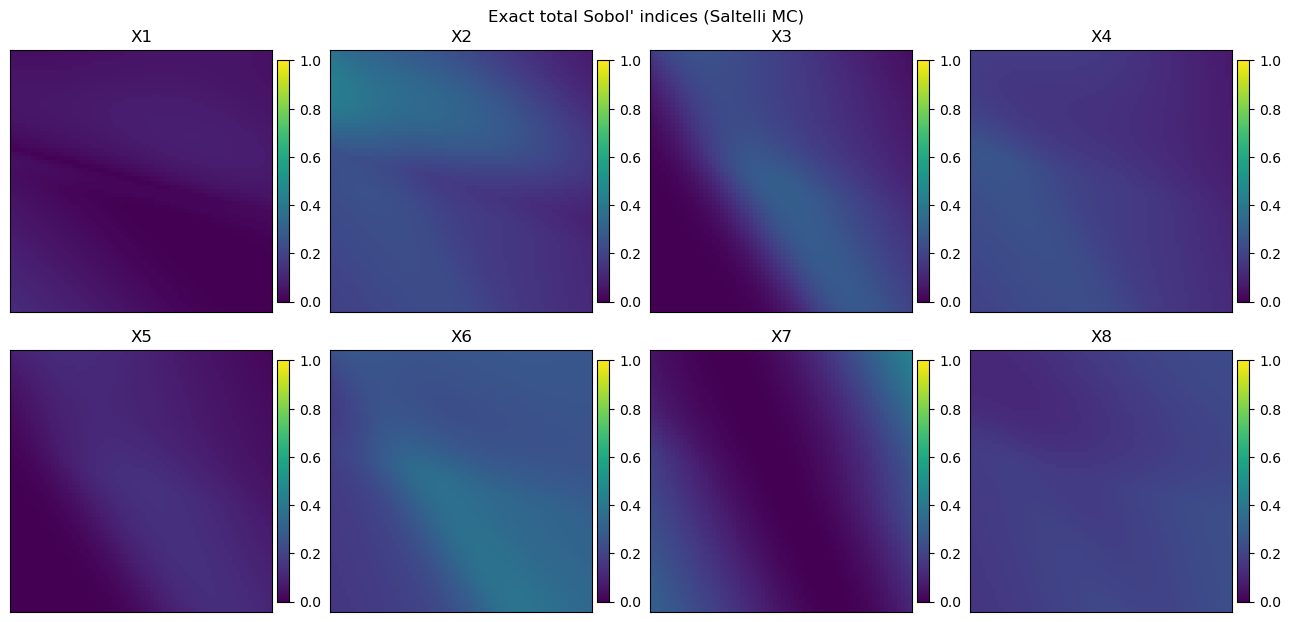

In [8]:
S_exact, ST_exact = saltelli_exact_sobol_maps(Z1, Z2, N=cfg.saltelli_N_exact, low=cfg.x_low, high=cfg.x_high, seed=2020, chunk=2000)

# Plot total-effect maps (Fig. 2 style)
titles = [f"X{i+1}" for i in range(cfg.d)]
fig = plot_index_grid(ST_exact, titles, suptitle="Exact total Sobol' indices (Saltelli MC)", ncols=4, vmin=0, vmax=1)
plt.show()


## Sobol maps from the functional metamodel (nested MC, Sec. 3.4)

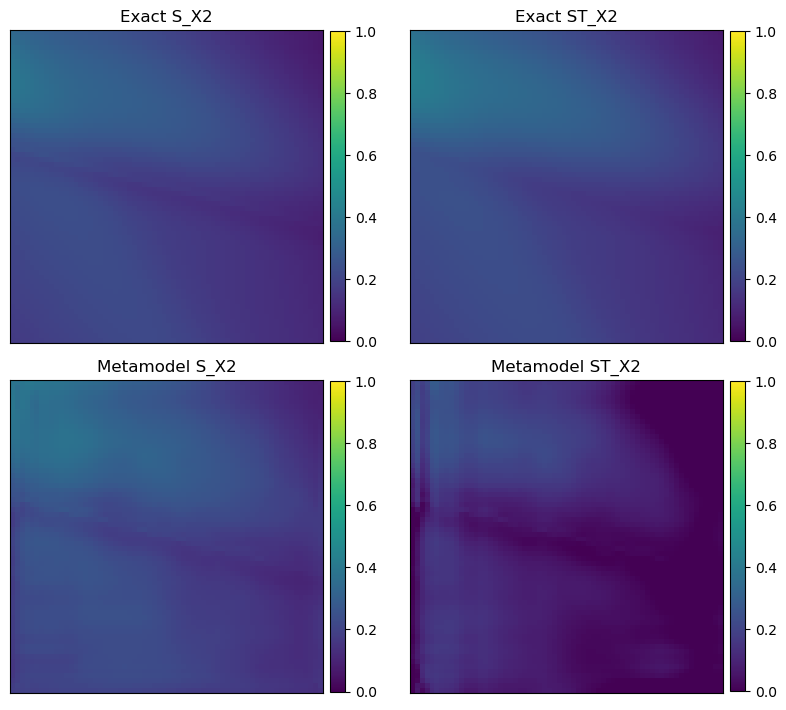

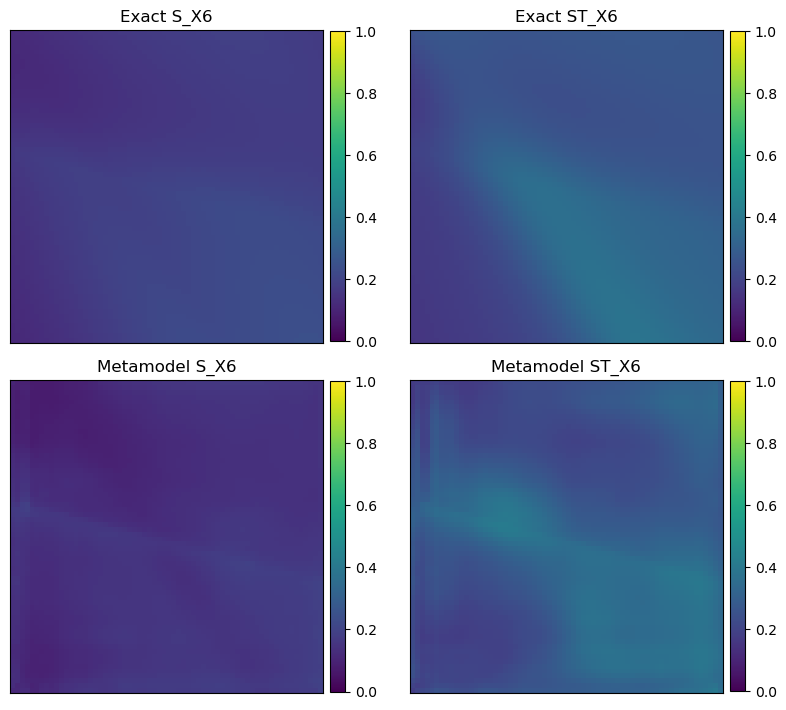

In [9]:
S_hat, ST_hat = nested_mc_sobol_maps(models,
    Z1=Z1, Z2=Z2,
    coeff_slices=coeff_slices, coeff_arr_shape=coeff_arr_shape,
    wavelet=cfg.wavelet, mu_map=mu_map, order=order,
    low=cfg.x_low, high=cfg.x_high,
    mc_outer_first=cfg.mc_outer_first, mc_inner_first=cfg.mc_inner_first,
    mc_outer_total=cfg.mc_outer_total, mc_inner_total=cfg.mc_inner_total,
    mc_varY=cfg.mc_varY,
    seed=7, chunk=2000
)

# Compare for X2 and X6 (Fig. 5 style)
for idx, name in [(1,"X2"), (5,"X6")]:
    fig, axes = plt.subplots(2,2, figsize=(8,7), constrained_layout=True)
    vmin = 0; vmax = 1
    plot_map(axes[0,0], S_exact[idx], f"Exact S_{name}", vmin=vmin, vmax=vmax)
    plot_map(axes[0,1], ST_exact[idx], f"Exact ST_{name}", vmin=vmin, vmax=vmax)
    plot_map(axes[1,0], S_hat[idx], f"Metamodel S_{name}", vmin=vmin, vmax=vmax)
    plot_map(axes[1,1], ST_hat[idx], f"Metamodel ST_{name}", vmin=vmin, vmax=vmax)
    for ax in axes.flat:
        im = ax.images[0]
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    plt.show()


## rMAE against exact first-order maps (Table 1 style)

In [10]:
rmae_vals = []
for i in range(cfg.d):
    rmae_vals.append(rmae(S_hat[i], S_exact[i]))
rmae_vals = np.array(rmae_vals)

paper_table1 = np.array([0.0875, 0.1625, 0.1635, 0.1280, np.nan, 0.1317, 0.1180, 0.0996])

print("Variable  rMAE(this)  rMAE(paper)")
for i in range(cfg.d):
    print(f"X{i+1:<2}      {rmae_vals[i]:.4f}     {paper_table1[i] if not np.isnan(paper_table1[i]) else '—'}")


Variable  rMAE(this)  rMAE(paper)
X1       0.3836     0.0875
X2       0.0965     0.1625
X3       0.2911     0.1635
X4       0.0835     0.128
X5       1.2895     —
X6       0.2287     0.1317
X7       0.0887     0.118
X8       0.1858     0.0996


## Save outputs (arrays) for later use

This writes a `results.npz` file containing:
- training design and maps
- exact and metamodel Sobol maps
- diagnostics (MSE, Q2, rMAE)


In [11]:
np.savez("results_wavelet.npz",
         X_train=X_train, Y_train=Y_train,
         S_exact=S_exact, ST_exact=ST_exact,
         S_hat=S_hat, ST_hat=ST_hat,
         mse=mse, q2=q2, rmae=rmae_vals)
print("Wrote results_wavelet.npz in the notebook working directory.")


Wrote results_wavelet.npz in the notebook working directory.
